In [6]:
# Cell 1: install libraries
!pip install --quiet opendatasets matplotlib
# TensorFlow is already installed in Colab, so we don't force reinstall to avoid kernel restarts.

In [7]:
# Cell 2: upload kaggle.json
from google.colab import files
print("Please upload your kaggle.json (get it from Kaggle Account -> Create API token).")
uploaded = files.upload()  # a file selector will open

Please upload your kaggle.json (get it from Kaggle Account -> Create API token).


Saving kaggle.json to kaggle (1).json


In [8]:
# Cell 3: move kaggle.json to ~/.kaggle
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls -la /root/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Oct 27 11:59 .
drwx------ 1 root root 4096 Oct 27 11:59 ..
-rw------- 1 root root   67 Oct 27 11:53 kaggle.json


In [10]:
# Cell 4: download dataset
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/techsash/waste-classification-data"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Shalini9791
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data


100%|██████████| 427M/427M [00:04<00:00, 97.4MB/s]


In [11]:
# Cell A: list dataset folder
!ls -la /content/waste-classification-data || ls -la ./waste-classification-data
!find /content/waste-classification-data -maxdepth 2 -type d -print

total 16
drwxr-xr-x 4 root root 4096 Oct 27 12:19 .
drwxr-xr-x 1 root root 4096 Oct 27 12:18 ..
drwxr-xr-x 3 root root 4096 Oct 27 12:18 dataset
drwxr-xr-x 4 root root 4096 Oct 27 12:18 DATASET
/content/waste-classification-data
/content/waste-classification-data/DATASET
/content/waste-classification-data/DATASET/TRAIN
/content/waste-classification-data/DATASET/TEST
/content/waste-classification-data/dataset
/content/waste-classification-data/dataset/DATASET


In [12]:
# Step 1: Prepare data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_gen.flow_from_directory(
    '/content/waste-classification-data/DATASET/TRAIN',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='training')

val_data = train_gen.flow_from_directory(
    '/content/waste-classification-data/DATASET/TRAIN',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [13]:
# Step 2: Build CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # change number if more than 2 waste classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Step 3: Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data)
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


565/565 ━━━━━━━━━━━━━━━━━━━━ 111s 189ms/step - accuracy: 0.7955 - loss: 0.4647 - val_accuracy: 0.7901 - val_loss: 0.4214
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 104s 183ms/step - accuracy: 0.8510 - loss: 0.3526 - val_accuracy: 0.7855 - val_loss: 0.4462
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 142s 183ms/step - accuracy: 0.8598 - loss: 0.3277 - val_accuracy: 0.8085 - val_loss: 0.4062
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 183ms/step - accuracy: 0.8850 - loss: 0.2795 - val_accuracy: 0.7994 - val_loss: 0.4419
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 182ms/step - accuracy: 0.9069 - loss: 0.2269 - val_accuracy: 0.8336 - val_loss: 0.4271
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 105s 186ms/step - accuracy: 0.9274 - loss: 0.1818 - val_accuracy: 0.8307 - val_loss: 0.5069
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 106s 187ms/step - accuracy: 0.9466 - loss: 0.1360 - val_accuracy: 0.8229 - val_loss: 0.5993
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 107s 189ms/step - accuracy: 0.9650 - loss: 0.09

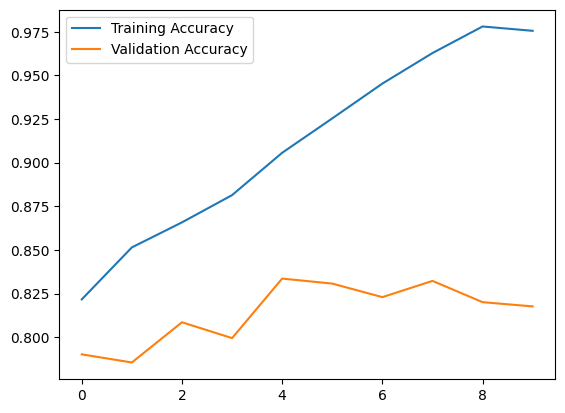

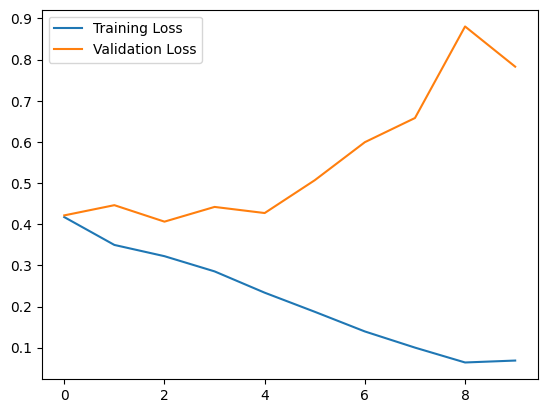

In [15]:
import matplotlib.pyplot as plt

# 📈 Accuracy graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# 📉 Loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

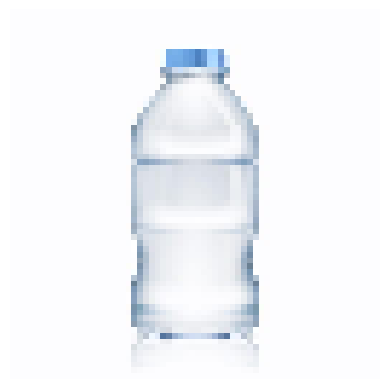

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
🌿 Predicted class: recyclable


In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np

# 🖼️ Give your own test image path here
# You can upload an image to Colab first (click 📁 on left → upload file)
img_path = '/content/plastic.jpeg'  # <-- change this name to your uploaded image

# 📏 Load and resize image
img = image.load_img(img_path, target_size=(64, 64))
plt.imshow(img)
plt.axis('off')
plt.show()

# 🔢 Convert image to array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# 🧠 Predict
prediction = model.predict(x)

# 🏷️ Class names (same as your dataset folder names)
classes = ['organic', 'recyclable']  # change names if different

predicted_class = classes[np.argmax(prediction)]
print("🌿 Predicted class:", predicted_class)